In [1]:
import os

print(os.getcwd())
os.chdir("../../")
os.getcwd()

/data01/dl23vitcas/dl_project/src/single_task_object_detection


'/data01/dl23vitcas/dl_project'

In [2]:
import sys
import argparse
import os

sys.argv = ["view", "--config", "config/single_task_object_detection.yaml"]

parser = argparse.ArgumentParser()
parser.add_argument("--config", type=str, required=True, help="Path to the config file")
args = parser.parse_args()

print(args.config)

config/single_task_object_detection.yaml


In [3]:
import torch
from torchvision.transforms import transforms
from config_experiments import config
from dataloader import VOC08Attr
from bbox_transform import resize_bounding_boxes

device = "cuda"
from bbox_transform import (
    apply_nms,
)

In [4]:
import torch
import torchvision.transforms.functional as F
from torchvision.utils import draw_bounding_boxes
import matplotlib.pyplot as plt
import numpy as np


def show(imgs):
    plt.rcParams["savefig.bbox"] = "tight"
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)  # (H, W)
        axs[0, i].imshow(np.asarray(img))  # (W, H, 3)
        # axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[]) # uncomment to remove axis in plot


def show_bounding_box(img_tensor, box, labels=None, color="white"):
    img_tensor = inverse_transform(img_tensor)
    show(draw_bounding_boxes(img_tensor, box, colors=color, labels=labels, width=1))


def show_bbox_with_transform(img, box, mean, std, labels=None, color="white"):
    img = inverse_transorm_with_normalize(img, mean, std)
    show(draw_bounding_boxes(img, box, colors=color, labels=labels, width=2))


def inverse_transorm_with_normalize(image, mean, std):
    image = np.array(image)
    for channel in range(3):
        image[channel] = image[channel] * std[channel] + mean[channel]
    image = np.clip(image, 0, 1)
    image = (image * 255).astype(np.uint8)
    image = torch.from_numpy(image)
    return image


def inverse_transform(image):
    image = np.array(image)
    image = np.clip(image, 0, 1)
    image = (image * 255).astype(np.uint8)
    image = torch.from_numpy(image)
    return image

In [5]:
from model import ObjectDetectionModel

model_path = "models/object_detection/model_2024-06-18_11-08.pth"
model = ObjectDetectionModel().to(device)
model.load_state_dict(torch.load(model_path, map_location=device))

<All keys matched successfully>

In [6]:
transform_val = transform = transforms.Compose(
    [
        transforms.Resize(
            size=config["transform"]["resize_values"],
            max_size=config["transform"]["max_size"],
        ),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=config["transform"]["mean"], std=config["transform"]["std"]
        ),
    ]
)
# dataset & dataloader

val_data = VOC08Attr(train=False, transform=transform_val)

In [7]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches


# Funzione per denormalizzare l'immagine
def denormalize(image, mean, std):
    image = image.clone()
    for t, m, s in zip(image, mean, std):
        t.mul_(s).add_(m)
    return image


# Funzione per visualizzare l'immagine con i bounding box
def show_image_with_boxes(image_tensor, boxes, mean, std):
    # Denormalizzare l'immagine
    image = denormalize(image_tensor, mean, std)
    image = image.numpy().transpose((1, 2, 0))  # Convertire da (C, H, W) a (H, W, C)

    fig, ax = plt.subplots(1)
    ax.imshow(image)

    # Aggiungere i bounding box
    for box in boxes:
        x1, y1, x2, y2 = box
        width = x2 - x1
        height = y2 - y1
        rect = patches.Rectangle(
            (x1, y1), width, height, linewidth=2, edgecolor="r", facecolor="none"
        )
        ax.add_patch(rect)

    plt.show()

In [8]:
import torch.nn.functional as F


def resize_image(image, orig_size):
    return F.interpolate(
        image.unsqueeze(0), size=orig_size, mode="bilinear", align_corners=False
    ).squeeze(0)

In [10]:
import yaml

with open(
    os.getcwd()
    + "/src/single_task_object_detection/"
    + "target_mean_std_by_class.yaml",
    "r",
) as f:
    mean_std_by_class = yaml.safe_load(f)

GROUND TRUTH
tensor([[ 55.0000,   1.0000, 456.0000, 375.0000]], device='cuda:0')
['tvmonitor']

PREDICTION

tensor([[  1.3500, 123.7351,  13.9611, 207.0213],
        [ 81.8288, 188.0643, 437.9400, 362.8384],
        [  0.0000, 263.5494, 479.0342, 373.8378],
        [107.8075,   0.0000, 397.3179, 326.3258],
        [ 63.1061,   1.5271, 451.6985, 318.7889]], device='cuda:0')
['person', 'boat', 'diningtable', 'pottedplant', 'train']
tensor([0.7134, 0.5731, 0.8716, 0.6283, 0.3289], device='cuda:0')


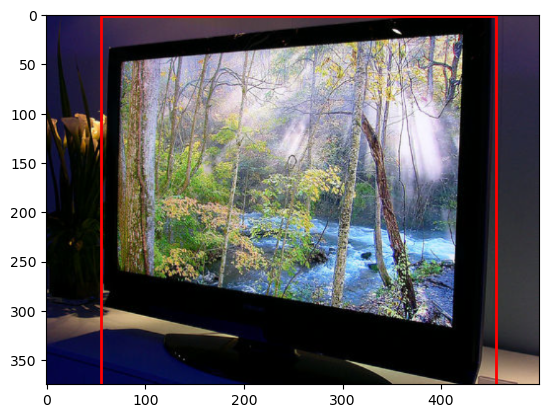

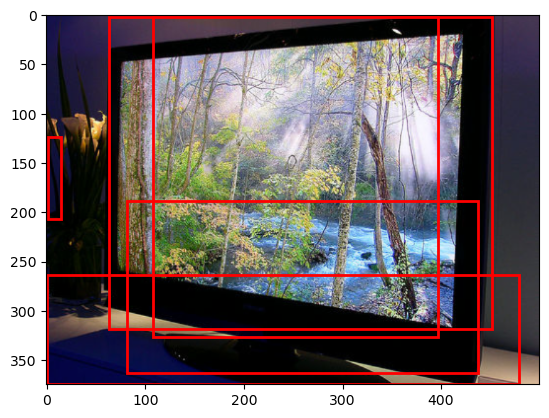

In [15]:
i = torch.randint(0, 100, (1,)).item()

model.eval()

with torch.no_grad():
    image, image_size, gt_class, gt_bbox, gt_attributes, ss_rois = val_data[i]
    image = image.unsqueeze(0).to(device)
    gt_class = gt_class.to(device)
    gt_bbox = gt_bbox.to(device)
    ss_rois = ss_rois.to(device)
    orig_w, orig_h = image_size
    new_w, new_h = (image.shape[3], image.shape[2])
    gt_bbox = resize_bounding_boxes(
        gt_bbox, orig_size=(new_w, new_h), new_size=(orig_w, orig_h)
    )

    indices_batch = val_data.get_indices_batch(
        image.shape[0], ss_rois.shape[0]
    ).unsqueeze(-1)

    indices_batch = indices_batch.to(device)

    cls_max_score_net, max_score_net, bboxs_net = model.prediction_img(
        image, ss_rois, indices_batch, mean_std_by_class
    )

    pred_bbox, pred_class, pred_score = apply_nms(
        cls_max_score_net, max_score_net, bboxs_net
    )

    pred_bbox = resize_bounding_boxes(
        pred_bbox, orig_size=(new_w, new_h), new_size=(orig_w, orig_h)
    )


print("GROUND TRUTH")
print(gt_bbox)
print([val_data.id2category[classe.item()] for classe in gt_class])
print("\nPREDICTION\n")
print(pred_bbox)
print([val_data.id2category[classe.item()] for classe in pred_class])
print(pred_score)

original_image = resize_image(image.squeeze().cpu(), (orig_h, orig_w))
show_image_with_boxes(
    original_image,
    gt_bbox.cpu(),
    mean=config["transform"]["mean"],
    std=config["transform"]["std"],
)

show_image_with_boxes(
    original_image,
    pred_bbox.cpu(),
    mean=config["transform"]["mean"],
    std=config["transform"]["std"],
)